<a href="https://www.kaggle.com/code/mastersniffer/pix2pix-maps-on-multiple-gpu-s?scriptVersionId=145628877" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Num GPUs Available:  1
Loaded:  (1096, 256, 256, 3) (1096, 256, 256, 3)


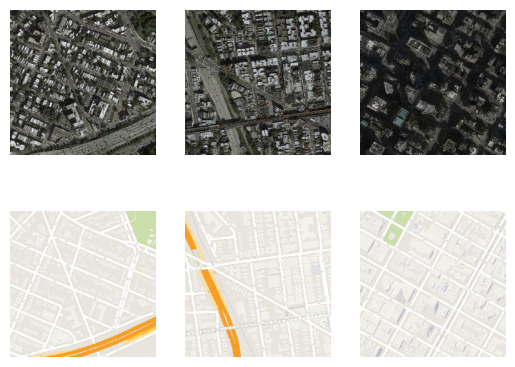

In [1]:
#Since pix2pix is a conditional GAN, it takes 2 inputs - image and corresponding label
#For pix2pix the label will be another image. 

# define the standalone discriminator model
#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (1 or 0). So using sigmoid activation.
#Think of discriminator as a binary classifier that is classifying images as real/fake.

# From the paper C64-C128-C256-C512
#After the last layer, conv to 1-dimensional output, followed by a Sigmoid function.  

import tensorflow as tf

import os
import time, gc

from matplotlib import pyplot as plt
from IPython import display
from os import listdir
from numpy import asarray, load
from numpy import vstack
import pandas as pd
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from numpy import savez_compressed
from matplotlib import pyplot
import numpy as np

from numpy import zeros
from numpy import ones
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model

from keras.models import load_model
from numpy.random import randint
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

strategy=None
if (len(tf.config.list_physical_devices('GPU'))>1):
    # You can choose any of these. Difference may be found here: https://www.tensorflow.org/guide/distributed_training
    #strategy = tf.distribute.MirroredStrategy()
    strategy = tf.distribute.MultiWorkerMirroredStrategy()


# load all images in a directory into memory
def load_images(path, size=(256,512)):
    src_list, tar_list = [], []
    # enumerate filenames in directory, assume all are images
    for filename in listdir(path):
        # load and resize the image
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # split into satellite and map
        sat_img, map_img = pixels[:, :256], pixels[:, 256:]
        src_list.append(sat_img)
        tar_list.append(map_img)
    return [asarray(src_list), asarray(tar_list)]

# dataset path
path = '../input/pix2pix-maps/train/'
# load dataset
[src_images, tar_images] = load_images(path)
print('Loaded: ', src_images.shape, tar_images.shape)

EPOCHS = 50
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(src_images[i].astype('uint8'))
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(tar_images[i].astype('uint8'))
pyplot.show()

## Discriminator

In [2]:
"""
Generator:    
The encoder-decoder architecture consists of:
encoder:
C64-C128-C256-C512-C512-C512-C512-C512
decoder:
CD512-CD512-CD512-C512-C256-C128-C64
Discriminator
C64-C128-C256-C512
After the last layer, a convolution is applied to map to
a 1-dimensional output, followed by a Sigmoid function.    
"""



def define_discriminator(image_shape):
        # weight initialization
        init = RandomNormal(stddev=0.02) #As described in the original paper

        # source image input
        in_src_image = Input(shape=image_shape)  #Image we want to convert to another image
        # target image input
        in_target_image = Input(shape=image_shape)  #Image we want to generate after training. 

        # concatenate images, channel-wise
        merged = Concatenate()([in_src_image, in_target_image])

        # C64: 4x4 kernel Stride 2x2
        d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(merged)
        d = LeakyReLU(alpha=0.2)(d)
        # C128: 4x4 kernel Stride 2x2
        d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C256: 4x4 kernel Stride 2x2
        d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # C512: 4x4 kernel Stride 2x2 
        # Not in the original paper. Comment this block if you want.
        d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # second last output layer : 4x4 kernel but Stride 1x1
        d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
        d = BatchNormalization()(d)
        d = LeakyReLU(alpha=0.2)(d)
        # patch output
        d = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
        patch_out = Activation('sigmoid')(d)
        # define model
        model = Model([in_src_image, in_target_image], patch_out)
        # compile model
        #The model is trained with a batch size of one image and Adam opt. 
        #with a small learning rate and 0.5 beta. 
        #The loss for the discriminator is weighted by 50% for each model update.

        opt = Adam(lr=0.0002, beta_1=0.5)
        model.compile(loss='binary_crossentropy', optimizer=opt, loss_weights=[0.5])
        return model

# disc_model = define_discriminator((256,256,3))
# plot_model(disc_model, to_file='disc_model.png', show_shapes=True)

## Generator

In [3]:
#Now define the generator - in our case we will define a U-net
# define an encoder block to be used in generator
def define_encoder_block(layer_in, n_filters, batchnorm=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add downsampling layer
    g = Conv2D(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # conditionally add batch normalization
    if batchnorm:
        g = BatchNormalization()(g, training=True)
    # leaky relu activation
    g = LeakyReLU(alpha=0.2)(g)
    return g

# define a decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # add upsampling layer
    g = Conv2DTranspose(n_filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(layer_in)
    # add batch normalization
    g = BatchNormalization()(g, training=True)
    # conditionally add dropout
    if dropout:
        g = Dropout(0.5)(g, training=True)
    # merge with skip connection
    g = Concatenate()([g, skip_in])
    # relu activation
    g = Activation('relu')(g)
    return g

# define the standalone generator model - U-net
def define_generator(image_shape=(256,256,3)):
    # weight initialization
    init = RandomNormal(stddev=0.02)
    # image input
    in_image = Input(shape=image_shape)
    # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
    e1 = define_encoder_block(in_image, 64, batchnorm=False)
    e2 = define_encoder_block(e1, 128)
    e3 = define_encoder_block(e2, 256)
    e4 = define_encoder_block(e3, 512)
    e5 = define_encoder_block(e4, 512)
    e6 = define_encoder_block(e5, 512)
    e7 = define_encoder_block(e6, 512)
    # bottleneck, no batch norm and relu
    b = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(e7)
    b = Activation('relu')(b)
    # decoder model: CD512-CD512-CD512-C512-C256-C128-C64
    d1 = decoder_block(b, e7, 512)
    d2 = decoder_block(d1, e6, 512)
    d3 = decoder_block(d2, e5, 512)
    d4 = decoder_block(d3, e4, 512, dropout=False)
    d5 = decoder_block(d4, e3, 256, dropout=False)
    d6 = decoder_block(d5, e2, 128, dropout=False)
    d7 = decoder_block(d6, e1, 64, dropout=False)
    # output
    g = Conv2DTranspose(image_shape[2], (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d7) #Modified 
    out_image = Activation('tanh')(g)  #Generates images in the range -1 to 1. So change inputs also to -1 to 1
    return Model(in_image, out_image)

# gen_model = define_generator((256,256,3))
# plot_model(gen_model, to_file='gen_model.png', show_shapes=True)

In [4]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model, image_shape):
    # make weights in the discriminator not trainable
    for layer in d_model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = False       #Descriminator layers set to untrainable in the combined GAN but 
                                                #standalone descriminator will be trainable. ??

    # define the source image
    in_src = Input(shape=image_shape)
    # suppy the image as input to the generator 
    gen_out = g_model(in_src)
    # supply the input image and generated image as inputs to the discriminator
    dis_out = d_model([in_src, gen_out])
    # src image as input, generated image and disc. output as outputs
    # Model takes 2 aruguments input and output
    model = Model(in_src, [dis_out, gen_out])
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)

    #Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
    #Authors suggested weighting BCE vs L1 as 1:100.
    model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1,100])
    return model


# select a batch of random samples, returns images and target
def generate_real_samples(dataset, n_samples, patch_shape):
    # unpack dataset
    trainA, trainB = dataset
    # choose random instances
    ix = randint(0, trainA.shape[0], n_samples)
    # retrieve selected images
    X1, X2 = trainA[ix], trainB[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, patch_shape, patch_shape, 1))
    return [X1, X2], y

# generate a batch of images, returns images and targets
def generate_fake_samples(g_model, samples, patch_shape):
    # generate fake instance
    X = g_model.predict(samples)
    # create 'fake' class labels (0)
    y = zeros((len(X), patch_shape, patch_shape, 1))
    return X, y

# generate samples and save as a plot and save the model
#GAN models do not converge, we just want to find a good balance between
#the generator and the discriminator. Therefore, it makes sense to periodically
#save the generator model and check how good the generated image looks. 
def summarize_performance(step, g_model, dataset, n_samples=10):
    # select a sample of input images
    [X_realA, X_realB], _ = generate_real_samples(dataset, n_samples, 1)
    # generate a batch of fake samples
    X_fakeB, _ = generate_fake_samples(g_model, X_realA, 1)
    # scale all pixels from [-1,1] to [0,1]
    X_realA = (X_realA + 1) / 2.0
    X_realB = (X_realB + 1) / 2.0
    X_fakeB = (X_fakeB + 1) / 2.0
    # plot real source images
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_realA[i])
    # plot generated target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples + i)
        plt.axis('off')
        plt.imshow(X_fakeB[i])
    # plot real target image
    for i in range(n_samples):
        plt.subplot(3, n_samples, 1 + n_samples*2 + i)
        plt.axis('off')
        plt.imshow(X_realB[i])
    # save plot to file
    filename1 = 'plot_%06d.png' % (step+1)
    plt.savefig(filename1)
    plt.close()
    # save the generator model
    filename2 = 'model_%06d.h5' % (step+1)
    g_model.save(filename2)
    print(f'>Saved: {filename1} and {filename2}')

# train pix2pix models
def train(d_model, g_model, gan_model, dataset, n_epochs=100, n_batch=1):
    # determine the output square shape of the discriminator
    n_patch = d_model.output_shape[1]
    # unpack dataset
    trainA, trainB = dataset

    # calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    # calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    print("All steps in sum", n_steps)
    # manually enumerate epochs
    out_put = []
    for i in range(n_steps):
        # select a batch of real samples
        [X_realA, X_realB], y_real = generate_real_samples(dataset, n_batch, n_patch)
        # generate a batch of fake samples
        X_fakeB, y_fake = generate_fake_samples(g_model, X_realA, n_patch)
        # update discriminator for real samples
        d_loss1 = d_model.train_on_batch([X_realA, X_realB], y_real)
        # update discriminator for generated samples
        d_loss2 = d_model.train_on_batch([X_realA, X_fakeB], y_fake)
        # update the generator
        g_loss, _, _ = gan_model.train_on_batch(X_realA, [y_real, X_realB])   ## ?? why training generator with decriminiatior
        # summarize performance
        out_put.append((i+1, d_loss1, d_loss2, g_loss))
        if i%100 == 0:
            gc.collect()
            print('>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i+1, d_loss1, d_loss2, g_loss))
        # summarize model performance
        if (i+1) % (bat_per_epo * 10) == 0:
            gc.collect()
            summarize_performance(i, g_model, dataset)
    
    import pandas as pd
    df1 = pd.DataFrame(out_put)
    df1.to_csv('/kaggle/working/out_put.csv',index=False)


## Training

In [5]:
%%capture 

#from pix2pix_model import define_discriminator, define_generator, define_gan, train
# define input shape based on the loaded dataset
image_shape = src_images.shape[1:]
# define the models

if strategy:
    with strategy.scope():
        print("Using multiple GPU-s")
        d_model = define_discriminator(image_shape)
else:
    d_model = define_discriminator(image_shape)
        
        
if strategy:
    with strategy.scope():
        print("Using multiple GPU-s")
        g_model = define_generator(image_shape)
else:
    g_model = define_generator(image_shape)
    
# define the composite model
if strategy:
    with strategy.scope():
        print("Using multiple GPU-s")
        gan_model = define_gan(g_model, d_model, image_shape)
else:
    gan_model = define_gan(g_model, d_model, image_shape)

#Define data
# load and prepare training images
data = [src_images, tar_images]

def preprocess_data(data):
    # load compressed arrays
    # unpack arrays
    X1, X2 = data[0], data[1]
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

dataset = preprocess_data(data)

from datetime import datetime 
start1 = datetime.now() 

train(d_model, g_model, gan_model, dataset, n_epochs=EPOCHS, n_batch=8) 


stop1 = datetime.now()
#Execution time of the model 
execution_time = stop1-start1
print("Execution time is: ", execution_time)



2023-10-07 21:31:58.171674: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-07 21:32:13.290456: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_2/model_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


## Loading saved model

In [6]:
## Loading validation dataset
# dataset path
path = '../input/pix2pix-maps/val/'
# load dataset
[src_images_val, tar_images_val] = load_images(path)
print('Loaded: ', src_images_val.shape, tar_images_val.shape)

Loaded:  (1098, 256, 256, 3) (1098, 256, 256, 3)


In [7]:
data1 = [src_images_val, tar_images_val]
def preprocess_data(data):
    # load compressed arrays
    # unpack arrays
    X1, X2 = data[0], data[1]
    # scale from [0,255] to [-1,1]
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]

dataset = preprocess_data(data1)

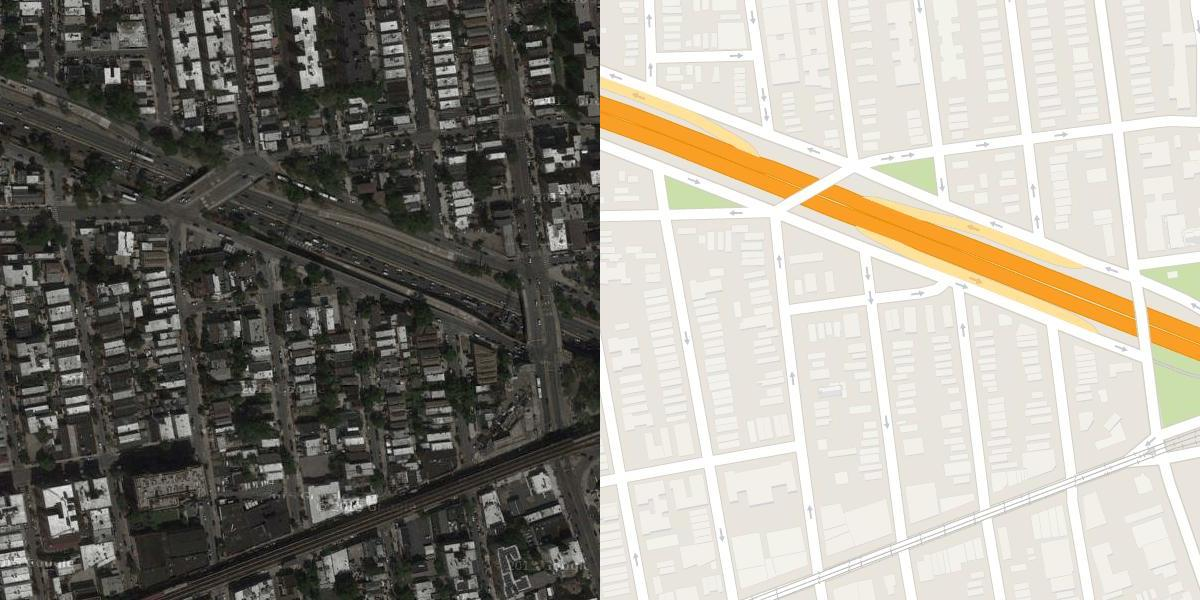

In [8]:
from PIL import Image
Image.open(r"../input/pix2pix-maps/train/2.jpg")

# Let's try another method

In [9]:
global_path = '../input/pix2pix-maps/'
train_path = f'{global_path}train/'
val_path = f'{global_path}val/'

BUFFER_SIZE = 400
BATCH_SIZE = 8
IMG_WIDTH = 256
IMG_HEIGHT = 256
OUTPUT_CHANNELS = 3
LAMBDA = 100

def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image)

  w = tf.shape(image)[1]

  w = w // 2
  real_image = image[:, :w, :]
  input_image = image[:, w:, :]

  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

<a id='preparation'></a>
### Data Preparation

In [10]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]
# normalizing the images to [-1, 1]

def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [11]:
# The `@tf.function()` decorator is used to convert the Python function `random_jitter` into a TensorFlow graph function.
# This allows the function to be compiled and optimized by TensorFlow, 
# resulting in improved performance when the function is called repeatedly. 
# The function takes `input_image` and `real_image` as input, performs various image processing operations
# such as resizing, cropping, and mirroring, and then returns the processed images.

@tf.function()
def random_jitter(input_image, real_image):
  """
   Randomly jumps an image to a real image. The jitter is random between 0 and 1.
   
   @param input_image - The image to jitter. Must be [ height width channels ].
   @param real_image - The image to jitter. Must be [ height width channels ].
   
   @return A tuple of 2 Tensors. The first is the input image and the second is the real
  """
  # resizing to 286 x 286 x 3
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # randomly cropping to 256 x 256 x 3
  input_image, real_image = random_crop(input_image, real_image)

  # Randomly mirroring the input image.
  if tf.random.uniform(()) > 0.5:
    # random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

In [12]:
# The code provided is defining two functions, `load_image_train` and `load_image_test`, and creating two datasets,
# `train_dataset` and `test_dataset`.

def load_image_train(image_file):
  """
   Loads an image and random jitters. The image is normalized to 0.
   
   @param image_file - Path to the image file.
   
   @return Tuple of two images : 1. The random jittered image
  """
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image
def load_image_test(image_file):
  """
   Load and resize image to be used for testing. Resizes and normalizes the image
   
   @param image_file - Path to image file.
   
   @return Tuple of ( input_image real_image )
  """
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image
train_dataset = tf.data.Dataset.list_files(f'{train_path}*.jpg')
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.list_files(f'{val_path}*.jpg')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

<a id='modules'></a>
### Prepare the downsample, upsample modules

In [13]:
# The code defines two functions: `downsample` and `upsample`.
def downsample(filters, size, apply_batchnorm=True):
  """
   Downsample the filter to a given size. This is a helper function for ` tf. keras. Sequential ` and ` tf. nn. Conv2D `.
   
   @param filters - The number of filters to downsample. Must be > 1.
   @param size - The size of the downsampled filter.
   @param apply_batchnorm - Whether to apply batch normalization.
   
   @return A Keras Sequential layer with the filters downsampled
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  # Add batch normalization to result.
  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, apply_dropout=False):
  """
   Creates a Keras Sequential layer that upsamples the input. This is useful for training and to avoid overfitting the model in the case of a pre - trained model.
   
   @param filters - The number of filters to upsample. Must be > 1.
   @param size - The size of the upsampled filters.
   @param apply_dropout - Whether to apply dropout.
   
   @return A Keras Sequential layer with the upsampled filters
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  # Add dropout to result.
  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

<a id='generator'></a>
### Generator

In [14]:
# The code defines a generator model for a conditional generative adversarial network (cGAN). 
# The generator takes an input image and generates a corresponding output image.
def Generator():
  """
   Generator layer for Keras. The output of this layer is used to predict the model parameters and biases.
   
   
   @return A tuple of ( weights biases ) where weights is a tensor of shape [ batch_size height width channels ] biases is a tensor of shape [ batch_size height width channels
  """
  inputs = tf.keras.layers.Input(shape=[256,256,3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False), # (bs, 128, 128, 64)
    downsample(128, 4), # (bs, 64, 64, 128)
    downsample(256, 4), # (bs, 32, 32, 256)
    downsample(512, 4), # (bs, 16, 16, 512)
    downsample(512, 4), # (bs, 8, 8, 512)
    downsample(512, 4), # (bs, 4, 4, 512)
    downsample(512, 4), # (bs, 2, 2, 512)
    downsample(512, 4), # (bs, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
    upsample(512, 4), # (bs, 16, 16, 1024)
    upsample(256, 4), # (bs, 32, 32, 512)
    upsample(128, 4), # (bs, 64, 64, 256)
    upsample(64, 4), # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh') # (bs, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  # Add a down to the stack.
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  # Concatenate up_stack and skip.
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

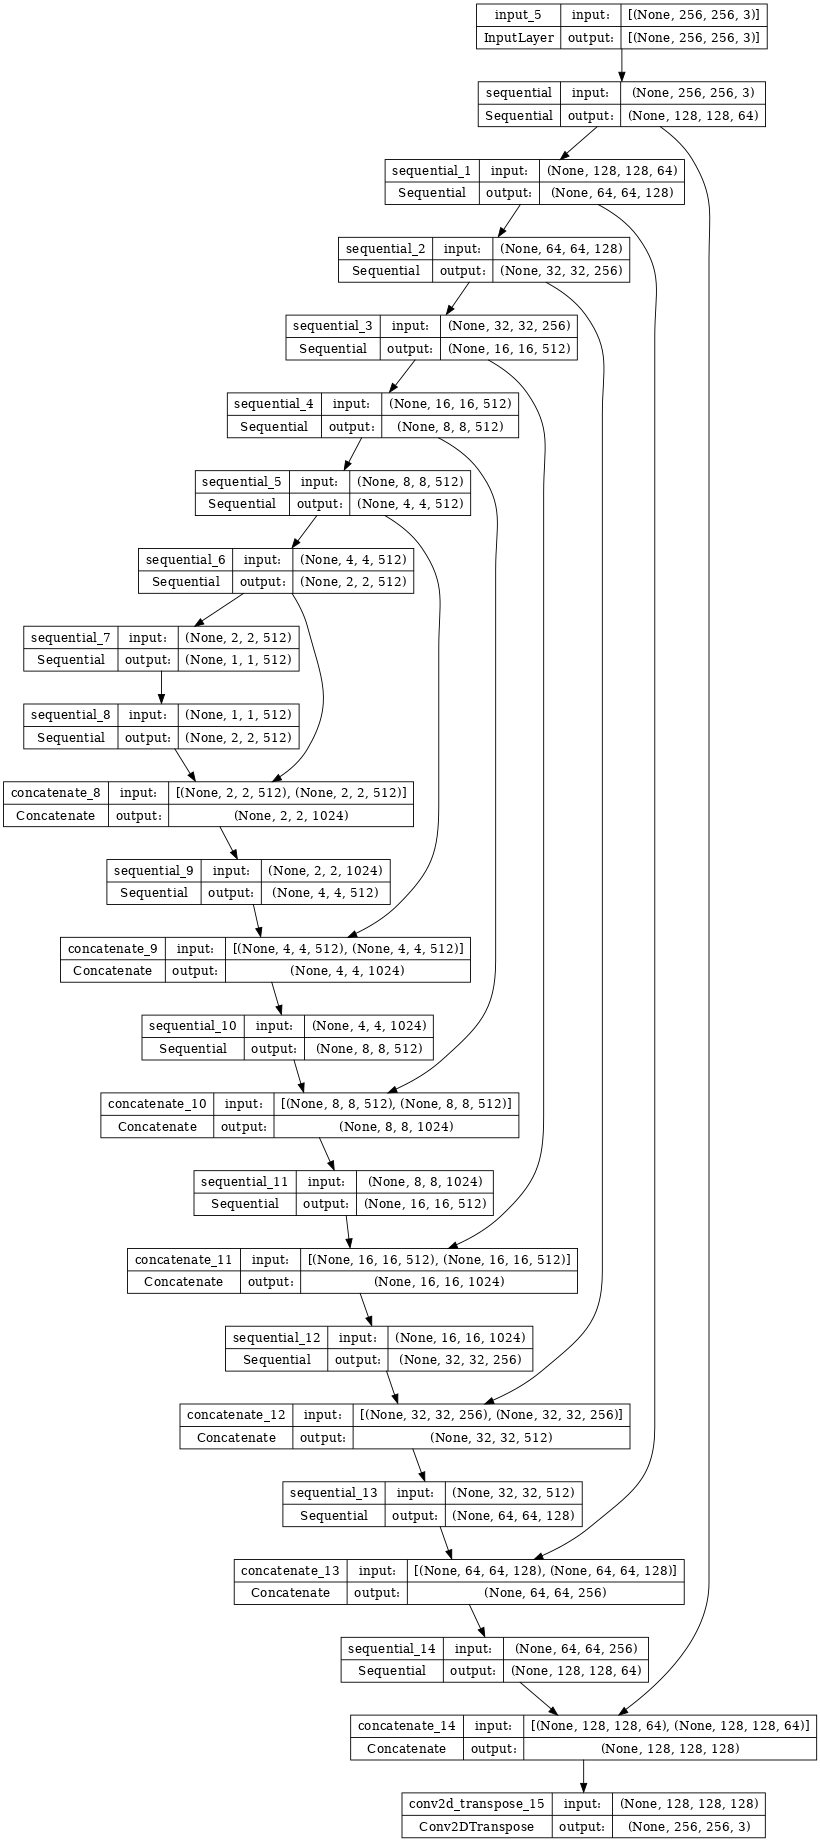

In [15]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [16]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

<a id='disccriminator'></a>
### Discriminator

This code defines a discriminator model for an image-to-image translation task. The discriminator is responsible for distinguishing between real and generated images.

The discriminator model is defined as a function called `Discriminator()`. Inside this function, the code initializes a random normal initializer with mean 0 and standard deviation 0.02.

The function takes two inputs: `inp` and `tar`, which represent the input image and the target image, respectively. Both images have a shape of [256, 256, 3].

The code then concatenates the input and target images using the `tf.keras.layers.concatenate()` function. This results in a tensor of shape (batch_size, 256, 256, channels*2), where `channels` is the number of channels in the input and target images.

The concatenated tensor is passed through three downsampling layers (`down1`, `down2`, and `down3`) using the `downsample()` function. Each downsampling layer reduces the spatial dimensions of the tensor while increasing the number of channels. The `downsample()` function takes the number of filters, kernel size, and a boolean flag indicating whether to apply batch normalization.

After the downsampling layers, the tensor is zero-padded using the `tf.keras.layers.ZeroPadding2D()` layer. This adds padding to the tensor to maintain its spatial dimensions.

The zero-padded tensor is then passed through a convolutional layer (`conv`) with 512 filters, a kernel size of 4, and a stride of 1. The convolutional layer uses the random normal initializer defined earlier and does not use bias. This layer performs a convolution operation on the input tensor, resulting in a tensor of shape (batch_size, 31, 31, 512).

The output of the convolutional layer is passed through a batch normalization layer (`batchnorm1`) to normalize the activations. Batch normalization helps stabilize the training process by reducing internal covariate shift.

The normalized tensor is then passed through a leaky ReLU activation function (`leaky_relu`). The leaky ReLU function introduces a small negative slope to the negative part of the activation, which helps prevent dead neurons.

The leaky ReLU output is zero-padded again using the `tf.keras.layers.ZeroPadding2D()` layer. This adds padding to the tensor to maintain its spatial dimensions.

Finally, the zero-padded tensor is passed through a convolutional layer (`last`) with 1 filter, a kernel size of 4, and a stride of 1. This layer performs a convolution operation on the input tensor, resulting in a tensor of shape (batch_size, 30, 30, 1). The output of this layer represents the discriminator's prediction for each patch of the input image.

The function returns a `tf.keras.Model` object that takes the input and target images as inputs and outputs the discriminator's prediction for each patch of the input image.

In [17]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar]) # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
  down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
  down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)


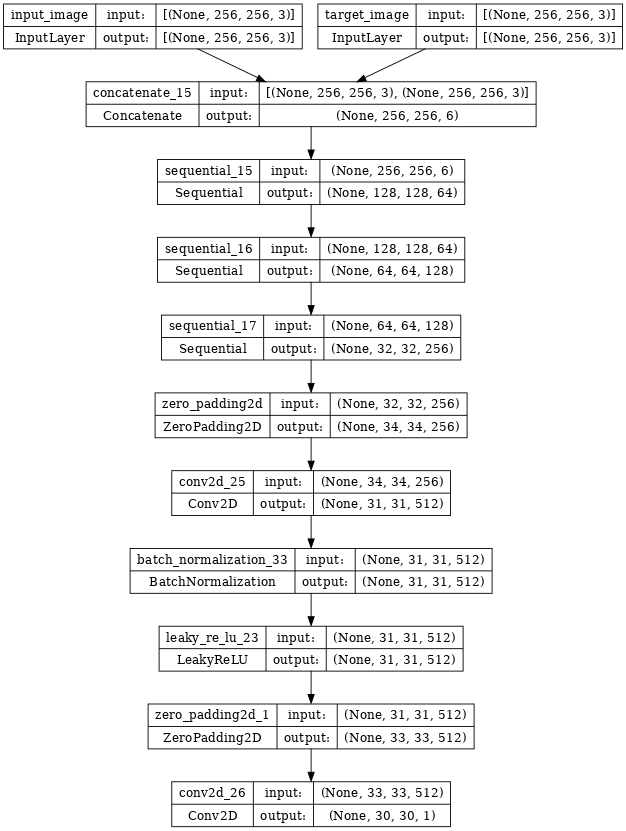

In [18]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [19]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  return real_loss + generated_loss

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

<a id='plot'></a>
### Plot generated images

In [22]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15,15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

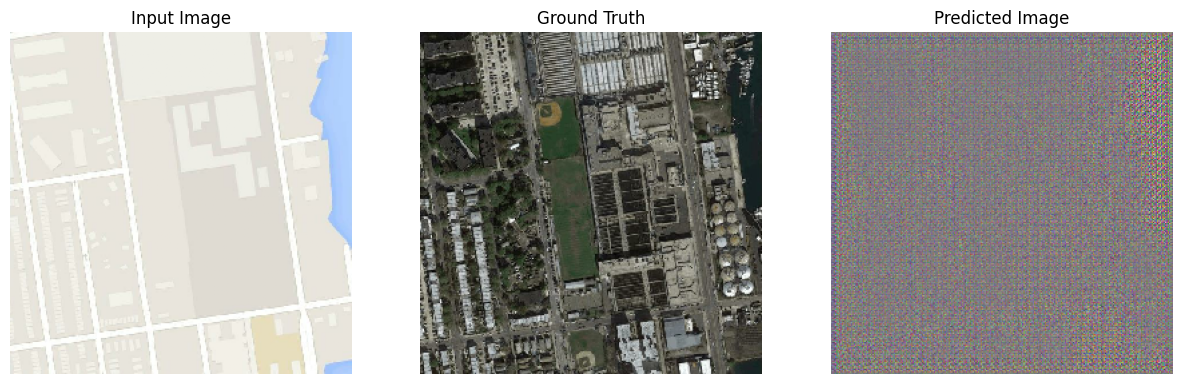

In [23]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

<a id='training'></a>
### Training

This code is a part of a training loop for a machine learning model. It is using TensorFlow to train a generator and discriminator model.

The `train_step` function is the main function that performs a single training step. It takes an input image and its corresponding target image as inputs, along with the current epoch number. Inside the function, it uses two `tf.GradientTape` contexts to record the operations for calculating the gradients of the generator and discriminator models.

First, it generates an output image using the generator model and the input image. Then, it calculates the outputs of the discriminator model for both the real target image and the generated image. These outputs are used to calculate the losses for the generator and discriminator models.

The generator loss is calculated using the `generator_loss` function, which takes the discriminator outputs for the generated image, the generated image itself, and the target image as inputs. The discriminator loss is calculated using the `discriminator_loss` function, which takes the discriminator outputs for the real and generated images as inputs.

After calculating the losses, the function calculates the gradients of the generator and discriminator models with respect to their trainable variables using the `gradient` method of the `tf.GradientTape` contexts. These gradients are then used to update the trainable variables of the generator and discriminator models using the `apply_gradients` method of the optimizer objects.

The `fit` function is the main training loop. It takes the training dataset, the number of epochs, and the test dataset as inputs. Inside the loop, it first clears the output and generates some example images using the generator model and a sample input image from the test dataset.

Then, it iterates over the training dataset using the `enumerate` method to get the index and the input and target images. For every 100th iteration, it prints a dot to show the progress. It then calls the `train_step` function to perform a single training step.

After completing the training loop for each epoch, it prints the time taken for that epoch.

Overall, this code implements a training loop for a generator and discriminator model using TensorFlow. It performs a single training step for each input image and target image pair in the training dataset, updating the trainable variables of the models based on the calculated losses and gradients.

In [24]:
import gc

@tf.function
def train_step(input_image, target, epoch):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
  
  
def fit(train_ds, epochs, test_ds):
  for epoch in range(epochs):
    start = time.time()

    display.clear_output(wait=True)

    for example_input, example_target in test_ds.take(1):
      generate_images(generator, example_input, example_target)
    print("Epoch: ", epoch)

    # Train
    for n, (input_image, target) in train_ds.enumerate():
      print('.', end='')
      if (n+1) % 100 == 0:
        gc.collect()
        print()
      train_step(input_image, target, epoch)
    print()

    print(f'Time taken for epoch {epoch + 1} is {time.time() - start} sec\n')

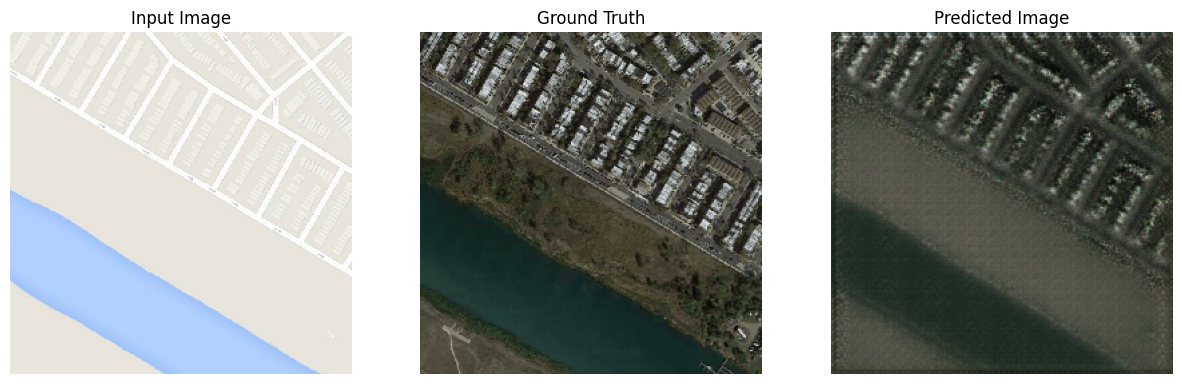

Epoch:  7
.

2023-10-07 22:14:50.600122: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_3/sequential_8/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


...................................................................................................
.....................................
Time taken for epoch 8 is 28.880192756652832 sec



In [25]:
fit(train_dataset, 8, test_dataset)